# Store Sales - Time Series Forecasting

[Kaggle Competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)


1. Initial Setup and Imports

In [5]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series specific
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet  

# Machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression

# Train model (example using XGBoost)
import xgboost as xgb


2. Data Loading and Exploration

In [6]:
# Load all datasets
train = pd.read_csv('./data/train.csv')
stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv')
holidays = pd.read_csv('./data/holidays_events.csv')

# Convert date columns
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# Basic information and statistics
print(train.info())
print(train.describe())

# Check for missing values
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000

3. Data Preprocessing

In [7]:
# Basic Time Features
def create_time_features(df):
    """Create basic time-based features"""
    df = df.sort_values('date')

    # Check for missing values in the date column
    missing_dates = df['date'].isnull().sum()
    print(f"Missing date values: {missing_dates}")

    # Handle missing values if any
    df['date'] = df['date'].fillna(method='bfill') # Backward fill


    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    
    # Paydays (15th and last day of month)
    df['is_payday'] = ((df['day_of_month'] == 15) | 
                       (df['date'].dt.is_month_end)).astype(int)
    
    return df

df = create_time_features(train)


Missing date values: 0


/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_45153/511463118.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['date'] = df['date'].fillna(method='bfill') # Backward fill


4. Exploratory Data Analysis (EDA)

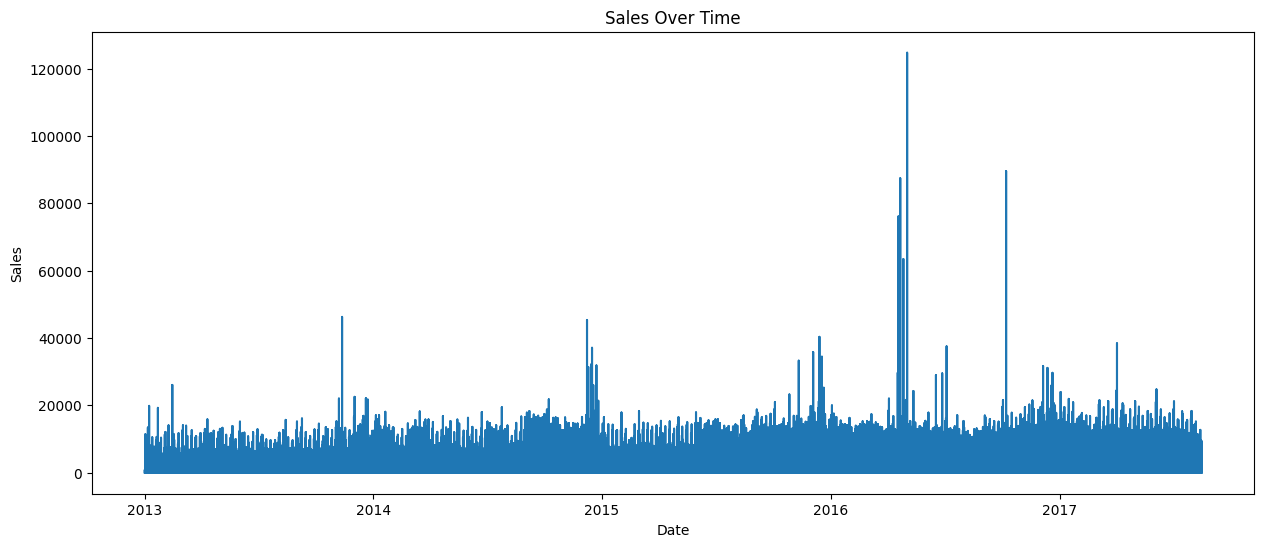

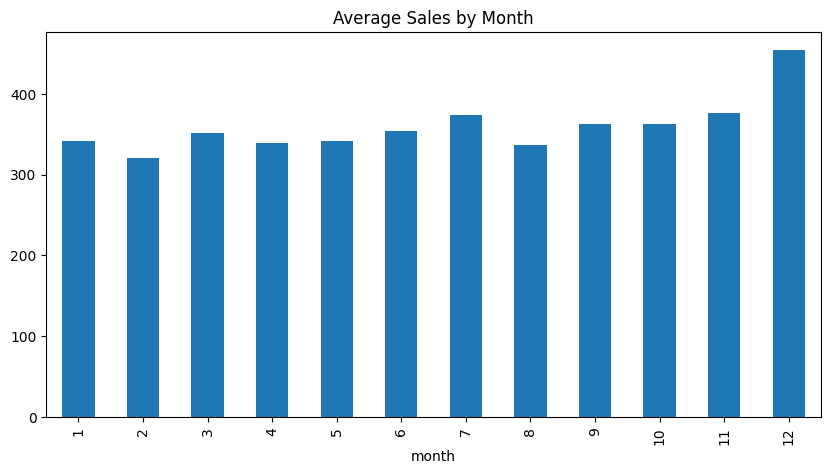

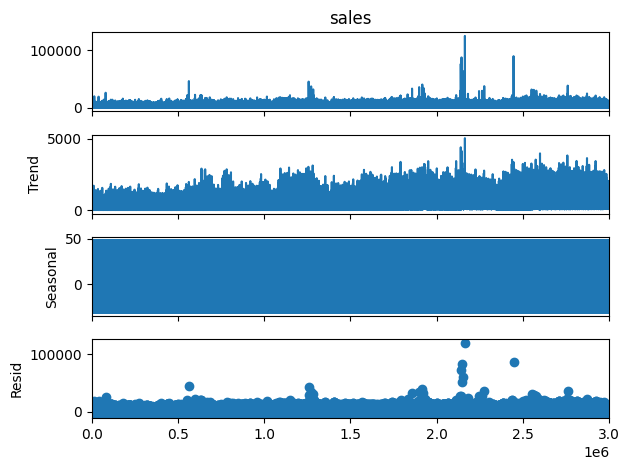

In [8]:
# Plot overall sales trend
plt.figure(figsize=(15,6))
plt.plot(df['date'], df['sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Monthly sales patterns
monthly_sales = df.groupby('month')['sales'].mean()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind='bar')
plt.title('Average Sales by Month')
plt.show()

# Decompose time series
decomposition = seasonal_decompose(df['sales'], period=30)  # adjust period as needed
decomposition.plot()
plt.show()

Analyzing sales patterns...


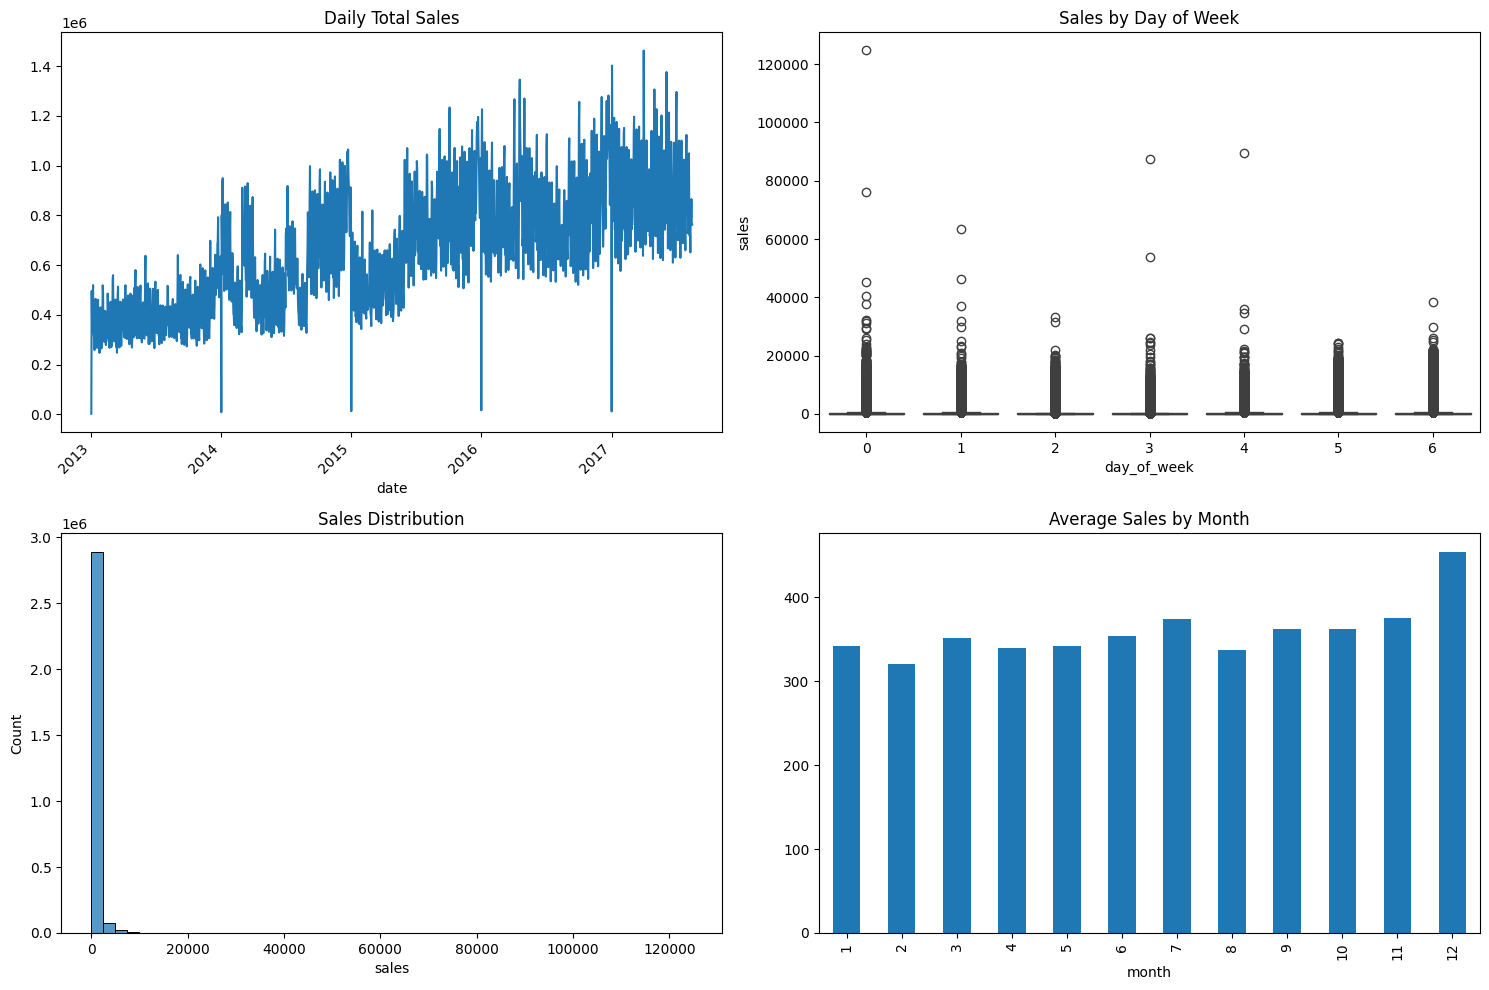

In [75]:
# 2. Basic Sales Analysis
def analyze_sales_patterns():
    """Analyze basic sales patterns"""
    plt.figure(figsize=(15, 10))
    
    # Overall sales trend
    plt.subplot(2, 2, 1)
    daily_sales = train.groupby('date')['sales'].sum()
    daily_sales.plot()
    plt.title('Daily Total Sales')
    plt.xticks(rotation=45)
    
    # Sales by day of week
    plt.subplot(2, 2, 2)
    train['day_of_week'] = train['date'].dt.dayofweek
    sns.boxplot(data=train, x='day_of_week', y='sales')
    plt.title('Sales by Day of Week')
    
    # Sales distribution
    plt.subplot(2, 2, 3)
    sns.histplot(data=train, x='sales', bins=50)
    plt.title('Sales Distribution')
    
    # Monthly sales pattern
    plt.subplot(2, 2, 4)
    train['month'] = train['date'].dt.month
    monthly_sales = train.groupby('month')['sales'].mean()
    monthly_sales.plot(kind='bar')
    plt.title('Average Sales by Month')
    
    plt.tight_layout()
    plt.show()

print("Analyzing sales patterns...")
analyze_sales_patterns()

Analyzing store impact...


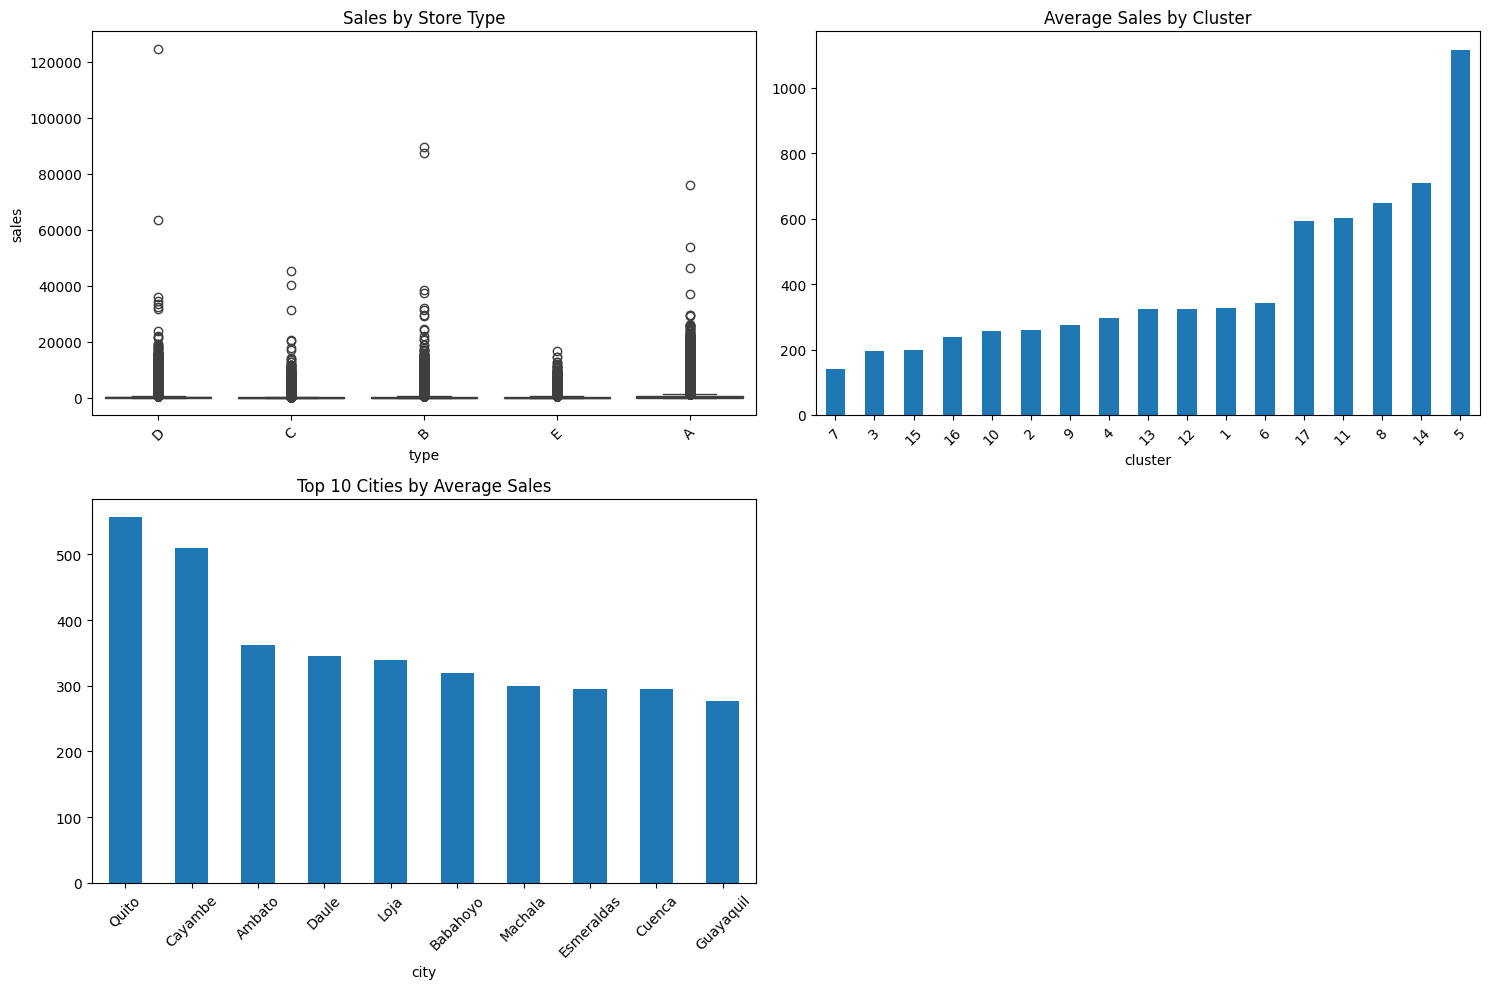


Store metrics summary:
            sales                 onpromotion
             mean      std  count        mean
store_nbr                                    
1          254.53   596.83  55572        2.48
2          387.92  1079.56  55572        2.85
3          908.41  2146.19  55572        3.19
4          340.27   801.13  55572        2.73
5          280.58   652.59  55572        2.69


In [9]:
# 3. Store Analysis
def analyze_store_impact():
    """Analyze how store characteristics affect sales"""
    # Merge store data
    store_sales = train.merge(stores, on='store_nbr')
    
    plt.figure(figsize=(15, 10))
    
    # Sales by store type
    plt.subplot(2, 2, 1)
    sns.boxplot(data=store_sales, x='type', y='sales')
    plt.title('Sales by Store Type')
    plt.xticks(rotation=45)
    
    # Sales by cluster
    plt.subplot(2, 2, 2)
    cluster_sales = store_sales.groupby('cluster')['sales'].mean().sort_values()
    cluster_sales.plot(kind='bar')
    plt.title('Average Sales by Cluster')
    plt.xticks(rotation=45)
    
    # Sales by city
    plt.subplot(2, 2, 3)
    city_sales = store_sales.groupby('city')['sales'].mean().sort_values(ascending=False)[:10]
    city_sales.plot(kind='bar')
    plt.title('Top 10 Cities by Average Sales')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate store metrics
    store_metrics = store_sales.groupby('store_nbr').agg({
        'sales': ['mean', 'std', 'count'],
        'onpromotion': 'mean'
    }).round(2)
    
    return store_metrics

print("Analyzing store impact...")
store_metrics = analyze_store_impact()
print("\nStore metrics summary:")
print(store_metrics.head())


Analyzing product families...


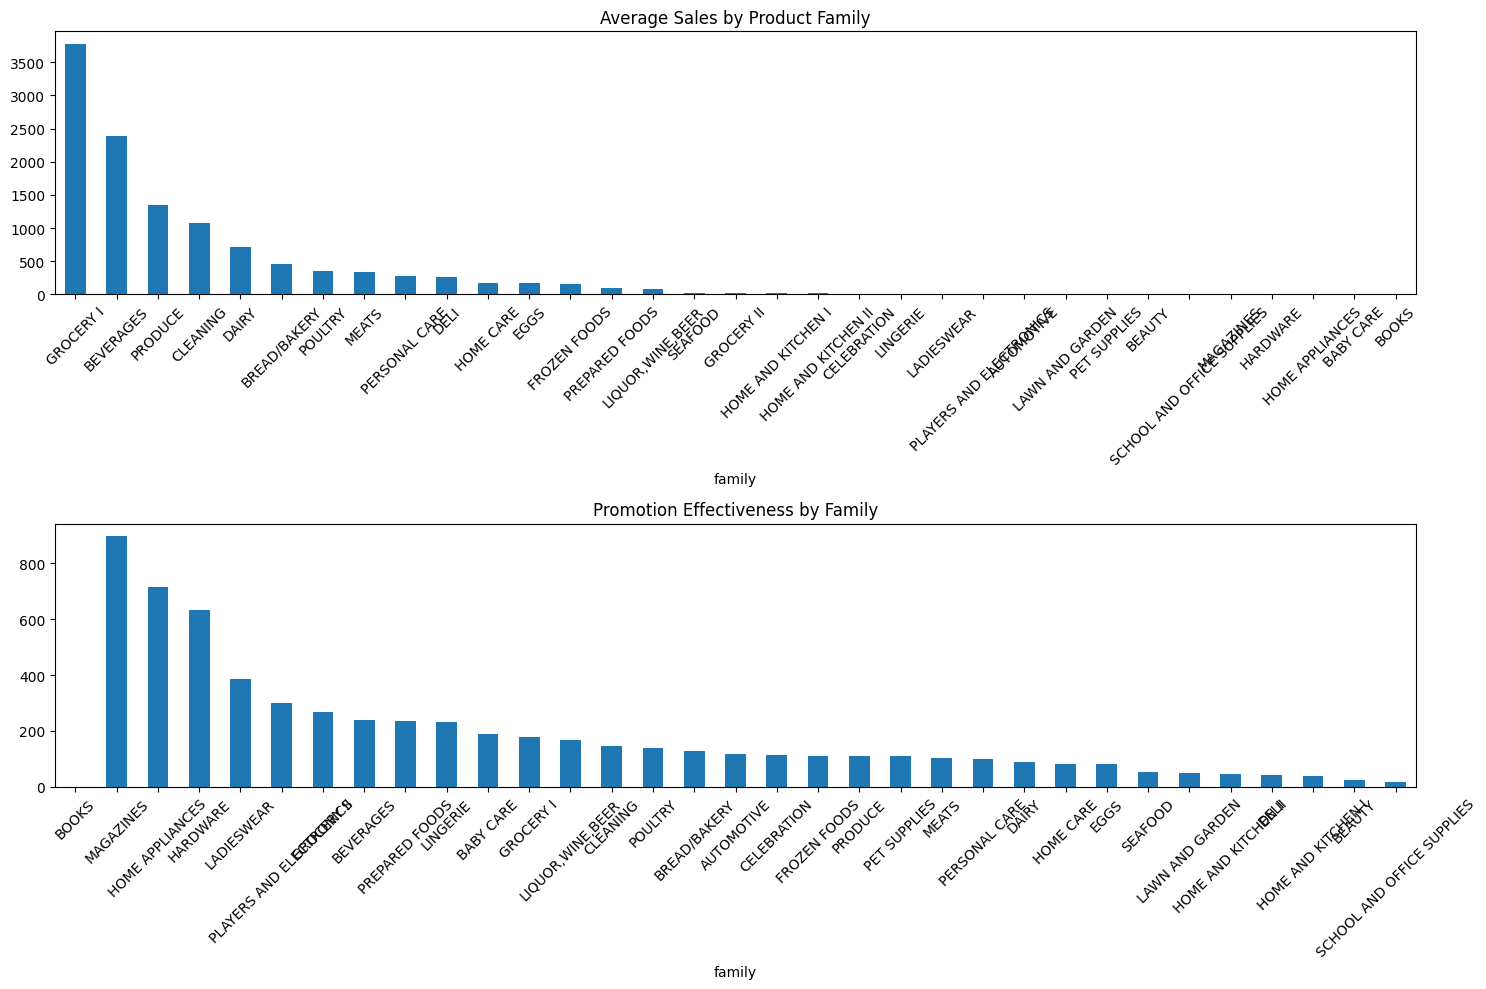


Product family promotion effectiveness:
                    sales  onpromotion  promo_effectiveness
family                                                     
BOOKS            0.070797     0.000000                  inf
MAGAZINES        2.929082     0.003266           896.831650
HOME APPLIANCES  0.457476     0.000638           717.258621
HARDWARE         1.137833     0.001792           634.785276
LADIESWEAR       7.160629     0.018475           387.594643


In [77]:

# 4. Product Family Analysis
def analyze_product_families():
    """Analyze sales patterns by product family"""
    plt.figure(figsize=(15, 10))
    
    # Average sales by family
    family_sales = train.groupby('family')['sales'].mean().sort_values(ascending=False)
    
    plt.subplot(2, 1, 1)
    family_sales.plot(kind='bar')
    plt.title('Average Sales by Product Family')
    plt.xticks(rotation=45)
    
    # Promotion effectiveness by family
    family_promo = train.groupby('family').agg({
        'sales': 'mean',
        'onpromotion': 'mean'
    })
    family_promo['promo_effectiveness'] = family_promo['sales'] / family_promo['onpromotion']
    
    plt.subplot(2, 1, 2)
    family_promo['promo_effectiveness'].sort_values(ascending=False).plot(kind='bar')
    plt.title('Promotion Effectiveness by Family')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return family_promo

print("Analyzing product families...")
family_promo = analyze_product_families()
print("\nProduct family promotion effectiveness:")
print(family_promo.sort_values('promo_effectiveness', ascending=False).head())


Analyzing promotions...


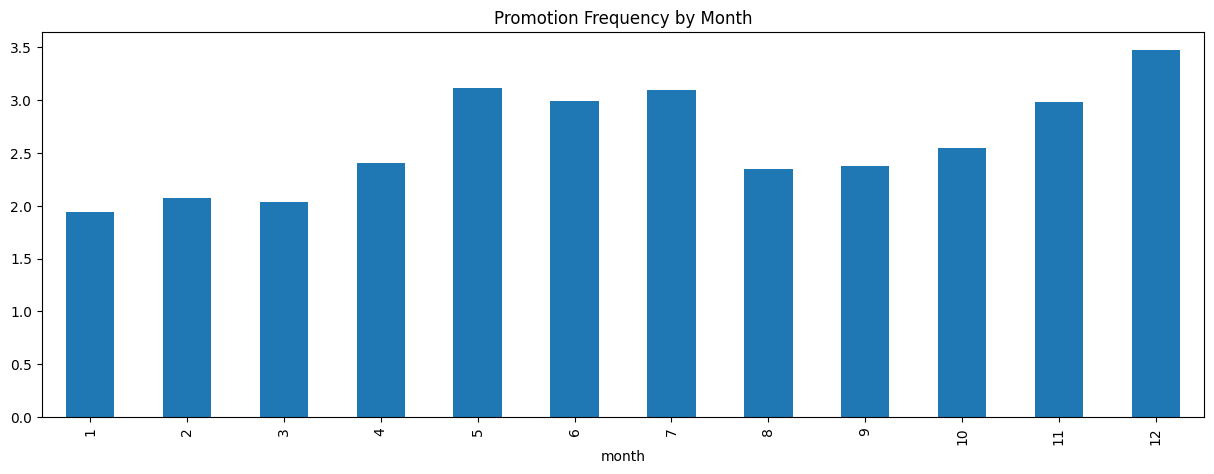


Promotion impact summary:
                    mean    count          std
onpromotion                                   
0             158.246681  2389559   614.894451
1             467.556532   174551   971.815817
2             662.925632    79386  1146.456129
3             871.408092    45862  1421.446624
4             969.916135    31659  1549.074833
...                  ...      ...          ...
719          6681.000000        1          NaN
720          6154.000000        1          NaN
722          5846.000000        1          NaN
726          6044.000000        1          NaN
741          7517.000000        1          NaN

[362 rows x 3 columns]


In [10]:

# 5. Promotion Analysis
def analyze_promotions():
    """Analyze the impact of promotions"""
    # Calculate promotion effectiveness
    promo_impact = train.groupby('onpromotion')['sales'].agg(['mean', 'count', 'std'])
    
    # Time-based promotion analysis
    train['month'] = train['date'].dt.month
    promo_by_month = train.groupby('month')['onpromotion'].mean()
    
    plt.figure(figsize=(15, 5))
    promo_by_month.plot(kind='bar')
    plt.title('Promotion Frequency by Month')
    plt.show()
    
    return promo_impact

print("Analyzing promotions...")
promo_impact = analyze_promotions()
print("\nPromotion impact summary:")
print(promo_impact)


Analyzing oil price impact...


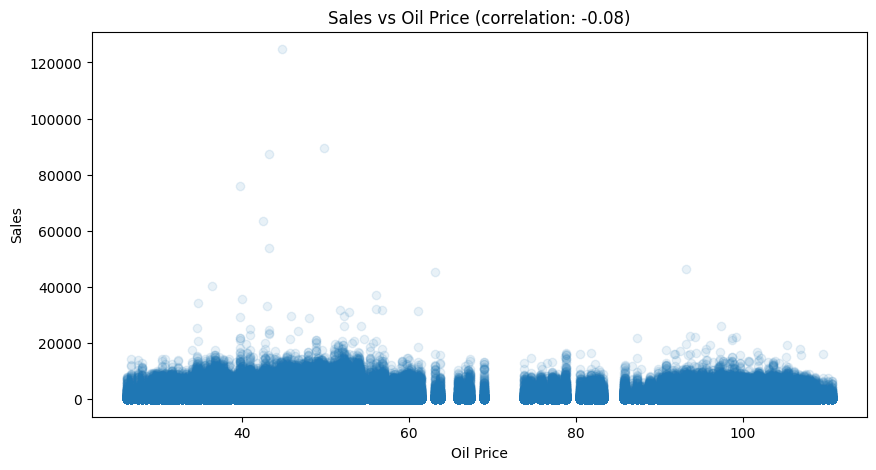


Oil price correlation with sales: -0.079


In [79]:
# 6. Oil Price Impact
def analyze_oil_impact():
    """Analyze relationship between oil prices and sales"""
    # Merge oil data
    sales_with_oil = train.merge(oil, on='date', how='left')
    
    # Calculate correlation
    correlation = sales_with_oil['sales'].corr(sales_with_oil['dcoilwtico'])
    
    plt.figure(figsize=(10, 5))
    plt.scatter(sales_with_oil['dcoilwtico'], sales_with_oil['sales'], alpha=0.1)
    plt.title(f'Sales vs Oil Price (correlation: {correlation:.2f})')
    plt.xlabel('Oil Price')
    plt.ylabel('Sales')
    plt.show()
    
    return correlation

print("Analyzing oil price impact...")
oil_correlation = analyze_oil_impact()
print(f"\nOil price correlation with sales: {oil_correlation:.3f}")


Analyzing holiday impact...


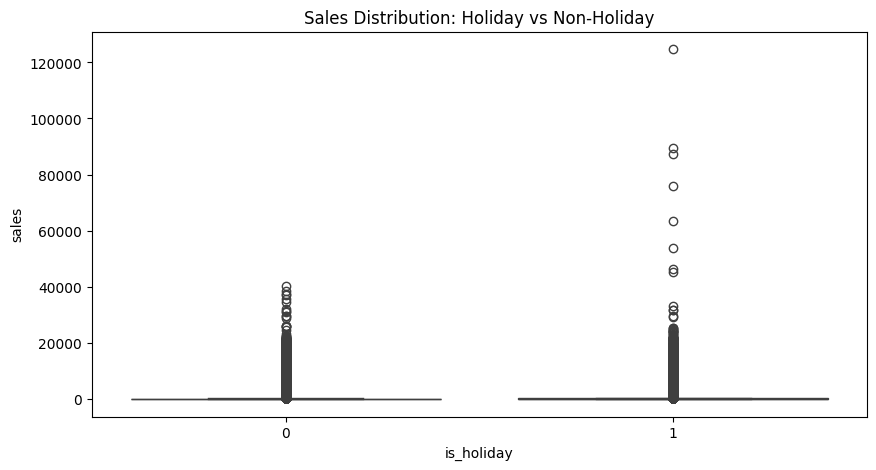


Holiday vs Non-holiday sales:
                  mean          std    count
is_holiday                                  
0           352.110696  1076.029594  2558952
1           390.578235  1241.224009   441936


In [80]:
# 7. Holiday Analysis
def analyze_holiday_impact():
    """Analyze sales patterns during holidays"""
    # Create holiday flag
    holiday_dates = holidays[holidays['type'] != 'Work Day']['date']
    train['is_holiday'] = train['date'].isin(holiday_dates).astype(int)
    
    # Compare sales on holidays vs non-holidays
    holiday_stats = train.groupby('is_holiday')['sales'].agg(['mean', 'std', 'count'])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train, x='is_holiday', y='sales')
    plt.title('Sales Distribution: Holiday vs Non-Holiday')
    plt.show()
    
    return holiday_stats

print("Analyzing holiday impact...")
holiday_stats = analyze_holiday_impact()
print("\nHoliday vs Non-holiday sales:")
print(holiday_stats)


In [81]:
# 8. Earthquake Impact Analysis
def analyze_earthquake_impact():
    """Analyze impact of the 2016 earthquake"""
    earthquake_date = pd.Timestamp('2016-04-16')
    
    # Create time windows around earthquake
    before_earthquake = train[
        (train['date'] >= earthquake_date - pd.Timedelta(days=30)) & 
        (train['date'] < earthquake_date)
    ]
    
    after_earthquake = train[
        (train['date'] >= earthquake_date) & 
        (train['date'] < earthquake_date + pd.Timedelta(days=30))
    ]
    
    # Compare sales
    comparison = pd.DataFrame({
        'before': before_earthquake['sales'].describe(),
        'after': after_earthquake['sales'].describe()
    })
    
    return comparison

print("Analyzing earthquake impact...")
earthquake_comparison = analyze_earthquake_impact()
print("\nSales before vs after earthquake:")
print(earthquake_comparison)


Analyzing earthquake impact...

Sales before vs after earthquake:
             before          after
count  53460.000000   53460.000000
mean     422.028199     497.406997
std     1197.638473    1657.391773
min        0.000000       0.000000
25%        2.000000       2.000000
50%       21.000000      23.000000
75%      244.418750     275.031000
max    22018.000000  124717.000000


Analyzing feature importance...


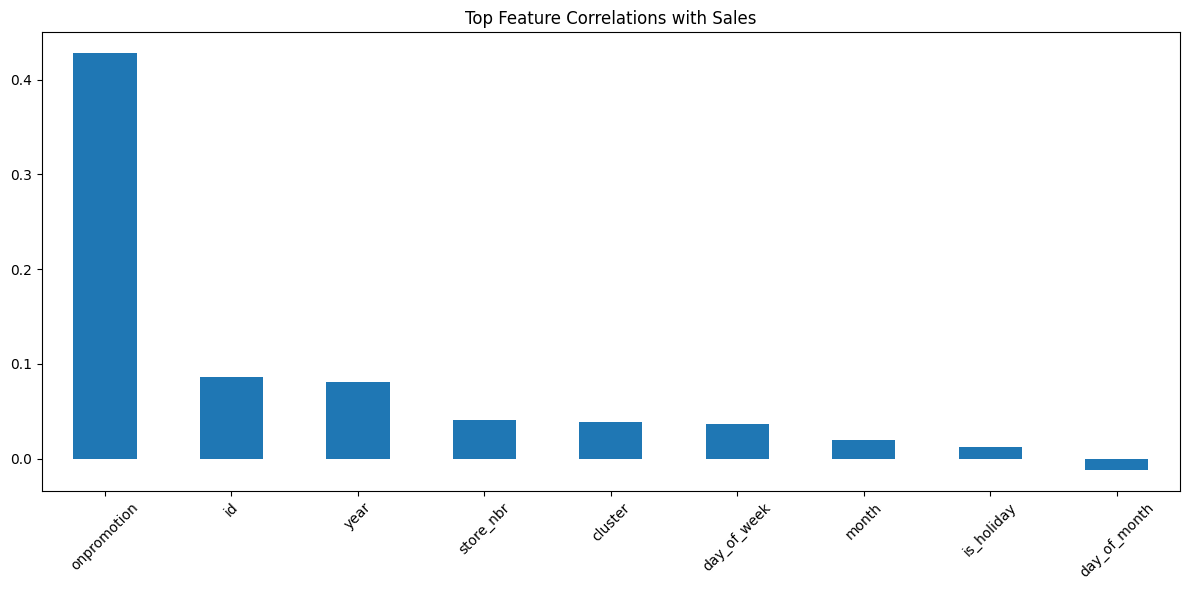


Top correlated features with sales:
sales           1.000000
onpromotion     0.427923
id              0.085784
year            0.081093
store_nbr       0.041196
cluster         0.038525
day_of_week     0.036869
month           0.019790
is_holiday      0.012370
day_of_month   -0.011887
Name: sales, dtype: float64


In [82]:
# 9. Feature Importance Analysis
def analyze_feature_importance():
    """Create and analyze initial features"""
    # Create basic features
    df = train.copy()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_month'] = df['date'].dt.day
    
    # Merge store data
    df = df.merge(stores, on='store_nbr')
    
    # Create dummy variables for categorical features
    df = pd.get_dummies(df, columns=['type', 'family'])
    
    # Drop non-numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Calculate correlations with sales
    correlations = df.corr()['sales'].sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    correlations[1:20].plot(kind='bar')  # Exclude sales correlation with itself
    plt.title('Top Feature Correlations with Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return correlations

print("Analyzing feature importance...")
feature_correlations = analyze_feature_importance()
print("\nTop correlated features with sales:")
print(feature_correlations.head(10))


5. Feature Engineering

In [11]:

# 1. Sales-related Features
def create_sales_features(df):
    """Create sales-related features"""
    # Group by store and family
    grouped = df.groupby(['store_nbr', 'family'])
    
    # Create lagged features
    lags = [1, 7, 14, 30]
    for lag in lags:
        df[f'sales_lag_{lag}'] = grouped['sales'].shift(lag)
    
    # Rolling means
    windows = [7, 14, 30]
    for window in windows:
        df[f'sales_rolling_mean_{window}'] = (
            grouped['sales'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
        )
        
    # Sales momentum (percent change)
    df['sales_momentum'] = grouped['sales'].pct_change()
    
    return df

# 2. Promotion Features
def create_promotion_features(df):
    """Create promotion-related features"""
    # Group by store and family
    grouped = df.groupby(['store_nbr', 'family'])
    
    # Rolling promotion metrics
    windows = [7, 14, 30]
    for window in windows:
        # Rolling mean of promotions
        df[f'promo_rolling_mean_{window}'] = (
            grouped['onpromotion'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
        )
    
    # Promotion changes
    df['promo_changed'] = grouped['onpromotion'].transform(
        lambda x: x.diff() != 0).astype(int)
    
    return df

# 3. Store Features
def create_store_features(df, stores_df):
    """Create store-related features"""
    # Merge store information
    df = df.merge(stores_df, on='store_nbr', how='left')
    
    # Create store type dummies
    store_type_dummies = pd.get_dummies(df['type'], prefix='store_type')
    df = pd.concat([df, store_type_dummies], axis=1)
    
    # Create city dummies (or use clustering for many cities)
    city_counts = df['city'].value_counts()
    major_cities = city_counts[city_counts > 100].index
    df['city_grouped'] = df['city'].apply(
        lambda x: x if x in major_cities else 'Other'
    )
    city_dummies = pd.get_dummies(df['city_grouped'], prefix='city')
    df = pd.concat([df, city_dummies], axis=1)
    
    return df

# 4. Oil Price Features
def create_oil_features(df, oil_df):
    """Create oil price related features"""
    # Merge oil prices
    df = df.merge(oil_df[['date', 'dcoilwtico']], on='date', how='left')
    
    # Forward fill missing oil prices
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
    
    # Create oil price changes
    df['oil_price_change'] = df['dcoilwtico'].pct_change()
    
    # Rolling oil statistics
    windows = [7, 14, 30]
    for window in windows:
        df[f'oil_rolling_mean_{window}'] = (
            df['dcoilwtico'].rolling(window=window, min_periods=1).mean()
        )
    
    return df

# 5. Holiday Features
def create_holiday_features(df, holidays_df):
    """Create holiday-related features"""
    # Clean up holidays dataframe
    holidays_df = holidays_df.copy()
    
    # Handle transferred holidays more efficiently
    transferred_days = holidays_df[holidays_df['type'] == 'Transfer']
    for _, row in transferred_days.iterrows():
        # Find the original holiday
        original = holidays_df[
            (holidays_df['description'] == row['description']) & 
            (holidays_df['type'] != 'Transfer')
        ]
        if not original.empty:
            # Update the date of the original holiday
            holidays_df.loc[original.index, 'date'] = row['date']
    
    # Create holiday flags using vectorized operations
    holiday_dates = set(holidays_df[holidays_df['type'] != 'Work Day']['date'])
    df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)
    
    # Create a Series for days to/from holiday using vectorized operations
    df['days_to_holiday'] = df['date'].apply(
        lambda x: min((x - d).days for d in holiday_dates if (x - d).days > 0) if holiday_dates else 99
    )
    df['days_from_holiday'] = df['date'].apply(
        lambda x: min((d - x).days for d in holiday_dates if (d - x).days > 0) if holiday_dates else 99
    )
    
    return df

# 6. Earthquake Feature (Special Event)
def create_earthquake_feature(df):
    """Create earthquake-related features"""
    earthquake_date = pd.Timestamp('2016-04-16')
    df['days_from_earthquake'] = (df['date'] - earthquake_date).dt.days
    df['earthquake_period'] = (
        (df['date'] >= earthquake_date) & 
        (df['date'] <= earthquake_date + pd.Timedelta(days=30))
    ).astype(int)
    
    return df

# 7. Put it all together
def engineer_features(df, stores_df, oil_df, holidays_df):
    """Main function to engineer all features"""
    print("Creating time features...")
    df = create_time_features(df)
    
    print("Creating sales features...")
    df = create_sales_features(df)
    
    print("Creating promotion features...")
    df = create_promotion_features(df)
    
    print("Creating store features...")
    df = create_store_features(df, stores_df)
    
    print("Creating oil features...")
    df = create_oil_features(df, oil_df)
    
    # print("Creating holiday features...")
    # df = create_holiday_features(df, holidays_df)
    
    print("Creating earthquake feature...")
    df = create_earthquake_feature(df)
    
    return df

# Use the feature engineering pipeline
df_engineered = engineer_features(train, stores, oil, holidays)

# Handle missing values
def handle_missing_values(df):
    """Handle missing values in the engineered features"""
    # Fill missing lagged values with 0
    lag_columns = [col for col in df.columns if 'lag' in col]
    df[lag_columns] = df[lag_columns].fillna(0)
    
    # Fill missing rolling means with the global mean
    rolling_columns = [col for col in df.columns if 'rolling' in col]
    for col in rolling_columns:
        df[col] = df[col].fillna(df[col].mean())
    
    # Fill other missing values
    df = df.fillna(0)
    
    return df

df_engineered = handle_missing_values(df_engineered)

# Save engineered features
df_engineered.to_csv('engineered_features.csv', index=False)

print(df_engineered.head())

Creating time features...
Missing date values: 0


/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_45153/511463118.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['date'] = df['date'].fillna(method='bfill') # Backward fill


Creating sales features...
Creating promotion features...
Creating store features...
Creating oil features...


/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_45153/2590496152.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')


Creating earthquake feature...
     id       date  store_nbr        family  sales  onpromotion  month  year  \
0     0 2013-01-01          1    AUTOMOTIVE    0.0            0      1  2013   
1  1194 2013-01-01         42   CELEBRATION    0.0            0      1  2013   
2  1193 2013-01-01         42  BREAD/BAKERY    0.0            0      1  2013   
3  1192 2013-01-01         42         BOOKS    0.0            0      1  2013   
4  1191 2013-01-01         42     BEVERAGES    0.0            0      1  2013   

   day_of_month  day_of_week  ...  city_Riobamba  city_Salinas  \
0             1            1  ...          False         False   
1             1            1  ...          False         False   
2             1            1  ...          False         False   
3             1            1  ...          False         False   
4             1            1  ...          False         False   

   city_Santo Domingo  dcoilwtico  oil_price_change  oil_rolling_mean_7  \
0               

6. Model Development

Train shape: (2974158, 67)
Test shape: (26730, 67)
Analyzing 33 features...

Top 10 correlations with sales:
sales                    1.000000
sales_rolling_mean_7     0.948087
sales_rolling_mean_14    0.941438
sales_rolling_mean_30    0.936116
sales_lag_7              0.934755
sales_lag_14             0.926094
sales_lag_1              0.918589
sales_lag_30             0.843825
promo_rolling_mean_30    0.550787
promo_rolling_mean_14    0.544124
Name: sales, dtype: float64
Checking for NaN values in X_train:
id                       0
store_nbr                0
onpromotion              0
day_of_week              0
month                    0
is_holiday               0
year                     0
day_of_month             0
is_weekend               0
week_of_year             0
day_of_year              0
quarter                  0
is_payday                0
sales_lag_1              0
sales_lag_7              0
sales_lag_14             0
sales_lag_30             0
sales_rolling_mean_7     0
s

/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_32656/3325036056.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.mean(), inplace=True)
/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_32656/3325036056.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_32656/3325036056.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan


Top 10 features by F-score:
                  Feature       F_Score  P_Value
17   sales_rolling_mean_7  2.643486e+07      0.0
18  sales_rolling_mean_14  2.318513e+07      0.0
19  sales_rolling_mean_30  2.107167e+07      0.0
14            sales_lag_7  2.058678e+07      0.0
15           sales_lag_14  1.791918e+07      0.0
13            sales_lag_1  1.606727e+07      0.0
16           sales_lag_30  7.354236e+06      0.0
23  promo_rolling_mean_30  1.295169e+06      0.0
22  promo_rolling_mean_14  1.250925e+06      0.0
21   promo_rolling_mean_7  1.223275e+06      0.0

Top 10 features by XGBoost importance:
                  Feature  XGB_Importance
17   sales_rolling_mean_7        0.490323
14            sales_lag_7        0.142128
18  sales_rolling_mean_14        0.136588
13            sales_lag_1        0.087619
15           sales_lag_14        0.045323
20         sales_momentum        0.018786
6                    year        0.018071
5              is_holiday        0.012333
8             

/Users/saraliu/Library/Caches/pypoetry/virtualenvs/titanic-SA5bcgBn-py3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/var/folders/kf/_5f4g2zd40n8t2rnn343psmc0000gn/T/ipykernel_32656/3325036056.py:93: RuntimeWarning: invalid value encountered in scalar subtract
  abs(train_mean - test_mean) / (abs(train_mean) + 1e-10) * 100


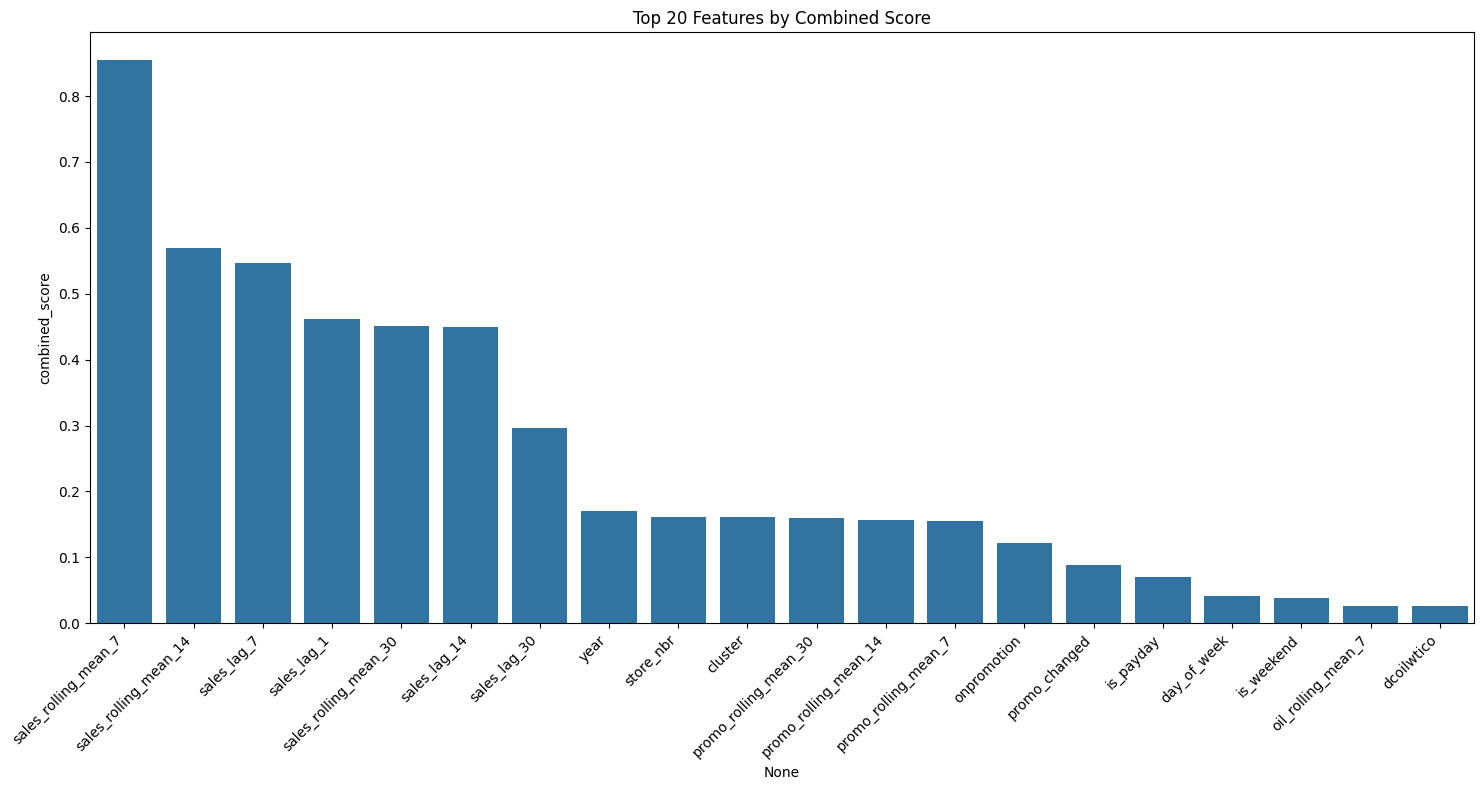


Selected 8 features above threshold

Top 20 selected features:
['sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_lag_7', 'sales_lag_1', 'sales_rolling_mean_30', 'sales_lag_14', 'sales_lag_30', 'year']


In [ ]:
# Split data into train and test (last 15 days)
test_dates = df_engineered['date'].max() - pd.Timedelta(days=15)
test_df = df_engineered[df_engineered['date'] > test_dates]
train_df = df_engineered[df_engineered['date'] <= test_dates]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Identify numeric features (excluding target and date)
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['sales', 'date']]

# Feature Analysis Function
def analyze_engineered_features(train_df, test_df, features):
    """
    Analyze engineered features and select the most important ones
    """
    print(f"Analyzing {len(features)} features...")
    
    # 1. Correlation with target
    correlations = train_df[features + ['sales']].corr()['sales'].sort_values(ascending=False)
    print("\nTop 10 correlations with sales:")
    print(correlations[:10])
    
    # 2. Feature Selection using SelectKBest
    X_train = train_df[features]
    y_train = train_df['sales']

    # Check for NaN values in X_train
    print("Checking for NaN values in X_train:")
    print(X_train.isnull().sum())  # This will show the count of NaN values for each feature

    # Check for infinite values in X_train
    print("Checking for infinite values in X_train:")
    print(np.isinf(X_train).sum())  # This will show the count of infinite values for each feature

    # Handle NaN values (example: fill with mean)
    X_train.fillna(X_train.mean(), inplace=True)

    # Handle infinite values (example: replace with a large finite number)
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
    X_train.fillna(X_train.mean(), inplace=True)  # Fill NaN again after replacing inf

    # Now you can proceed with fitting the model
        
    selector = SelectKBest(score_func=f_regression, k=50)
    selector.fit(X_train, y_train)

    # Get selected feature scores
    feature_scores = pd.DataFrame({
        'Feature': features,
        'F_Score': selector.scores_,
        'P_Value': selector.pvalues_
    }).sort_values('F_Score', ascending=False)
    
    print("\nTop 10 features by F-score:")
    print(feature_scores.head(10))
    
    # 3. XGBoost Feature Importance
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'XGB_Importance': model.feature_importances_
    }).sort_values('XGB_Importance', ascending=False)
    
    print("\nTop 10 features by XGBoost importance:")
    print(importance_df.head(10))
    
    # 4. Feature Stability Analysis
    stability_metrics = pd.DataFrame(index=features)
    
    for feature in features:
        train_mean = train_df[feature].mean()
        test_mean = test_df[feature].mean()
        train_std = train_df[feature].std()
        test_std = test_df[feature].std()
        
        stability_metrics.loc[feature, 'mean_diff_pct'] = (
            abs(train_mean - test_mean) / (abs(train_mean) + 1e-10) * 100
        )
        stability_metrics.loc[feature, 'std_diff_pct'] = (
            abs(train_std - test_std) / (abs(train_std) + 1e-10) * 100
        )
    
    # 5. Combine all metrics
    final_scores = pd.DataFrame(index=features)
    final_scores['correlation'] = abs(correlations)
    final_scores['f_score'] = feature_scores.set_index('Feature')['F_Score']
    final_scores['xgb_importance'] = importance_df.set_index('Feature')['XGB_Importance']
    final_scores['stability'] = 1 / (1 + stability_metrics['mean_diff_pct'])
    
    # Normalize scores
    for col in final_scores.columns:
        final_scores[col] = (final_scores[col] - final_scores[col].min()) / \
                           (final_scores[col].max() - final_scores[col].min())
    
    # Calculate combined score
    final_scores['combined_score'] = (
        final_scores['correlation'] * 0.25 +
        final_scores['f_score'] * 0.25 +
        final_scores['xgb_importance'] * 0.35 +
        final_scores['stability'] * 0.15
    )
    
    final_scores = final_scores.sort_values('combined_score', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(15, 8))
    sns.barplot(x=final_scores.head(20).index, y=final_scores.head(20)['combined_score'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 20 Features by Combined Score')
    plt.tight_layout()
    plt.show()
    
    # Select features above threshold
    threshold = final_scores['combined_score'].mean()
    selected_features = final_scores[final_scores['combined_score'] > threshold].index.tolist()
    
    return selected_features, final_scores

# Run the analysis
selected_features, feature_scores = analyze_engineered_features(train_df, test_df, numeric_features)

print(f"\nSelected {len(selected_features)} features above threshold")
print("\nTop 20 selected features:")
print(selected_features[:20])


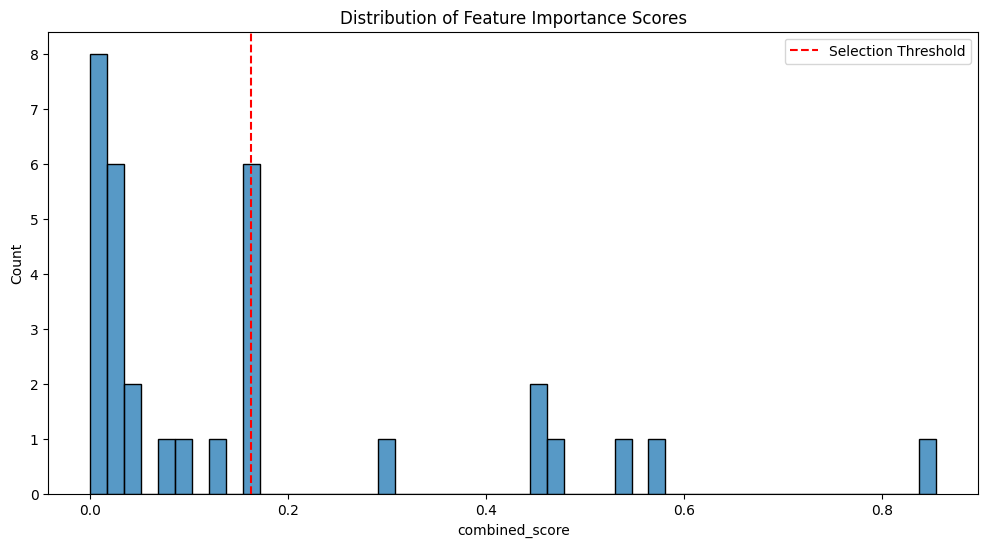

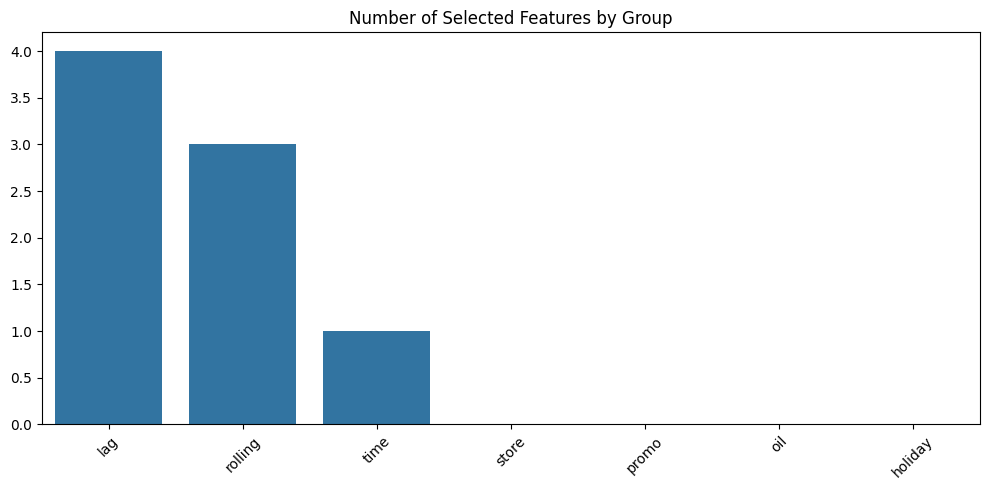


Most important features by group:

LAG:
  - sales_lag_7: 0.546
  - sales_lag_1: 0.461
  - sales_lag_14: 0.450

ROLLING:
  - sales_rolling_mean_7: 0.854
  - sales_rolling_mean_14: 0.569
  - sales_rolling_mean_30: 0.451

TIME:
  - year: 0.170

Analysis completed. Results saved to:
- feature_analysis_results.csv
- selected_features.txt


In [ ]:
# Save analysis results
feature_scores.to_csv('feature_analysis_results.csv')

# Visualize feature importance distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=feature_scores['combined_score'], bins=50)
plt.title('Distribution of Feature Importance Scores')
plt.axvline(x=feature_scores['combined_score'].mean(), color='r', linestyle='--', 
            label='Selection Threshold')
plt.legend()
plt.show()

# Additional Analysis: Feature Groups
def analyze_feature_groups(selected_features):
    """Analyze which types of engineered features were most useful"""
    feature_groups = {
        'lag': [f for f in selected_features if 'lag' in f],
        'rolling': [f for f in selected_features if 'rolling' in f],
        'time': [f for f in selected_features if any(x in f for x in ['day', 'month', 'year'])],
        'store': [f for f in selected_features if any(x in f for x in ['store', 'cluster'])],
        'promo': [f for f in selected_features if 'promo' in f],
        'oil': [f for f in selected_features if 'oil' in f],
        'holiday': [f for f in selected_features if 'holiday' in f]
    }
    
    group_counts = {k: len(v) for k, v in feature_groups.items()}
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(group_counts.keys()), y=list(group_counts.values()))
    plt.title('Number of Selected Features by Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return feature_groups

feature_groups = analyze_feature_groups(selected_features)

# Print summary of most important features by group
print("\nMost important features by group:")
for group, features in feature_groups.items():
    if features:
        top_features = feature_scores.loc[features].head(3).index.tolist()
        print(f"\n{group.upper()}:")
        for feat in top_features:
            score = feature_scores.loc[feat, 'combined_score']
            print(f"  - {feat}: {score:.3f}")

# Save final selected features
with open('selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

print("\nAnalysis completed. Results saved to:")
print("- feature_analysis_results.csv")
print("- selected_features.txt")


In [86]:
# Split data into train and test
test_dates = df_engineered['date'].max() - pd.Timedelta(days=15)
test_df = df_engineered[df_engineered['date'] > test_dates]
train_df = df_engineered[df_engineered['date'] <= test_dates]

# Prepare final training and test sets based on selected features
X_train = train_df[selected_features]
X_test = test_df[selected_features]
y_train = train_df['sales']
y_test = test_df['sales']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Model Training
def train_model():
    """Train XGBoost model with time-series cross-validation"""
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    
    # XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 1000,
        'max_depth': 7,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'eval_metric': 'rmse',
        'early_stopping_rounds': 50
    }
    
    # Track cross-validation scores
    cv_scores = []
    
    print("\nPerforming cross-validation...")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"\nFold {fold}")
        
        # Split data
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]
        
        # Train model
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            verbose=100
        )
        
        # Evaluate
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        cv_scores.append(rmse)
        
        print(f"Fold {fold} RMSE: {rmse:.4f}")
    
    print(f"\nCross-validation RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    # Train final model on full training set
    print("\nTraining final model...")
    final_model = xgb.XGBRegressor(**params)
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    return final_model, cv_scores

# Train model
print("Training model...")
model, cv_scores = train_model()

Training set shape: (2974158, 8)
Test set shape: (26730, 8)
Training model...

Performing cross-validation...

Fold 1
[0]	validation_0-rmse:691.67712	validation_1-rmse:882.03937
[100]	validation_0-rmse:288.88501	validation_1-rmse:411.22439
[200]	validation_0-rmse:166.28840	validation_1-rmse:286.69556
[300]	validation_0-rmse:137.98073	validation_1-rmse:261.39180
[400]	validation_0-rmse:131.35113	validation_1-rmse:258.03835
[445]	validation_0-rmse:130.02453	validation_1-rmse:258.38223
Fold 1 RMSE: 257.9833

Fold 2
[0]	validation_0-rmse:791.78319	validation_1-rmse:1012.15412
[100]	validation_0-rmse:342.45569	validation_1-rmse:448.56593
[200]	validation_0-rmse:211.01928	validation_1-rmse:295.31680
[300]	validation_0-rmse:181.16969	validation_1-rmse:266.03842
[400]	validation_0-rmse:173.64871	validation_1-rmse:262.35918
[469]	validation_0-rmse:171.07830	validation_1-rmse:262.69627
Fold 2 RMSE: 262.2781

Fold 3
[0]	validation_0-rmse:870.91512	validation_1-rmse:1188.16696
[100]	validation_0-r

In [88]:

# Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
        'Train MAE': mean_absolute_error(y_train, train_pred),
        'Test MAE': mean_absolute_error(y_test, test_pred)
    }
    
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Train predictions
    ax1.scatter(y_train, train_pred, alpha=0.5)
    ax1.plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2)
    ax1.set_title('Train: Actual vs Predicted')
    ax1.set_xlabel('Actual Sales')
    ax1.set_ylabel('Predicted Sales')
    
    # Test predictions
    ax2.scatter(y_test, test_pred, alpha=0.5)
    ax2.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
    ax2.set_title('Test: Actual vs Predicted')
    ax2.set_xlabel('Actual Sales')
    ax2.set_ylabel('Predicted Sales')
    
    plt.tight_layout()
    plt.show()
    
    return metrics, test_pred

7. Model Evaluation


Evaluating model...

Model Performance Metrics:
Train RMSE: 259.0707
Test RMSE: 239.7587
Train MAE: 62.5357
Test MAE: 74.5602


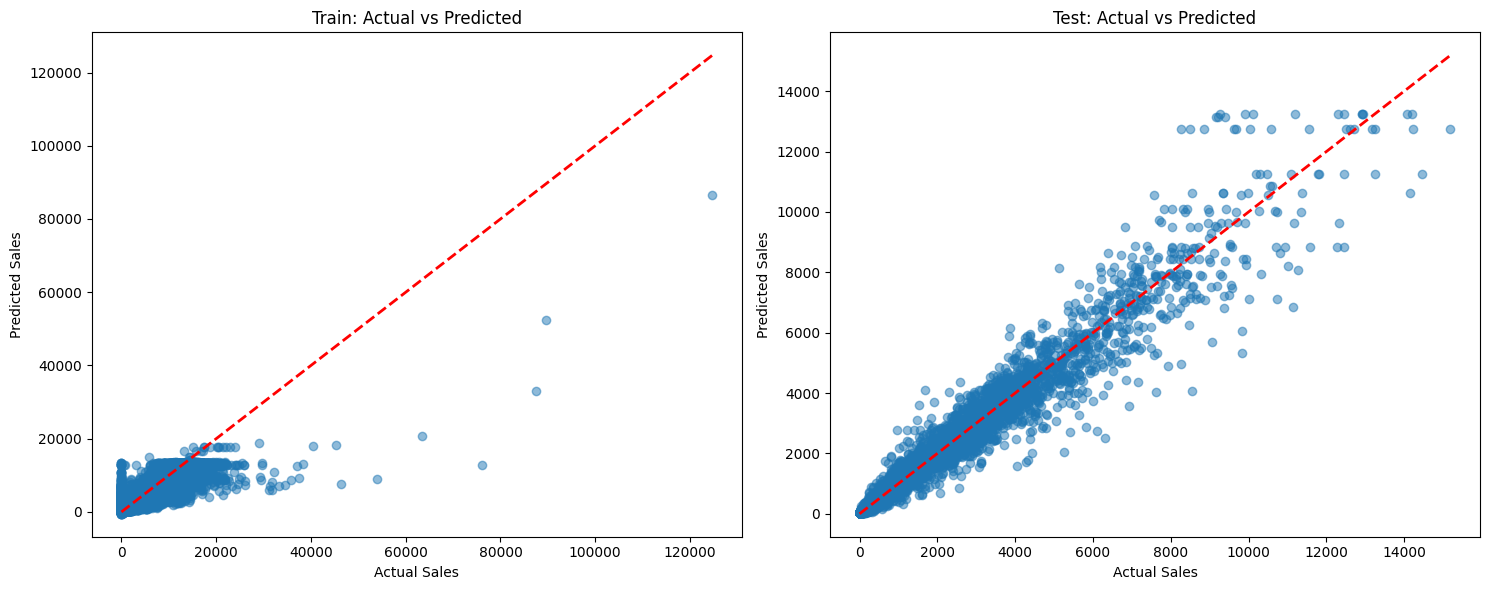


Results saved to:
- store_sales_model.json
- feature_importance.csv
- test_predictions.csv

Store Performance Summary:
          abs_error          error      
               mean     std   mean count
store_nbr                               
1             58.56  136.73 -24.34   495
2             53.04  107.62 -23.46   495
3             92.90  234.08 -26.68   495
4             58.78  134.97 -19.02   495
5             45.63  103.86 -15.87   495

Product Family Performance Summary:
           abs_error          error      
                mean     std   mean count
family                                   
AUTOMOTIVE     12.00    3.62 -11.97   810
BABY CARE      12.63    0.50 -12.63   810
BEAUTY         11.72    3.05 -11.57   810
BEVERAGES     507.55  571.44   9.78   810
BOOKS          12.73    0.11 -12.73   810


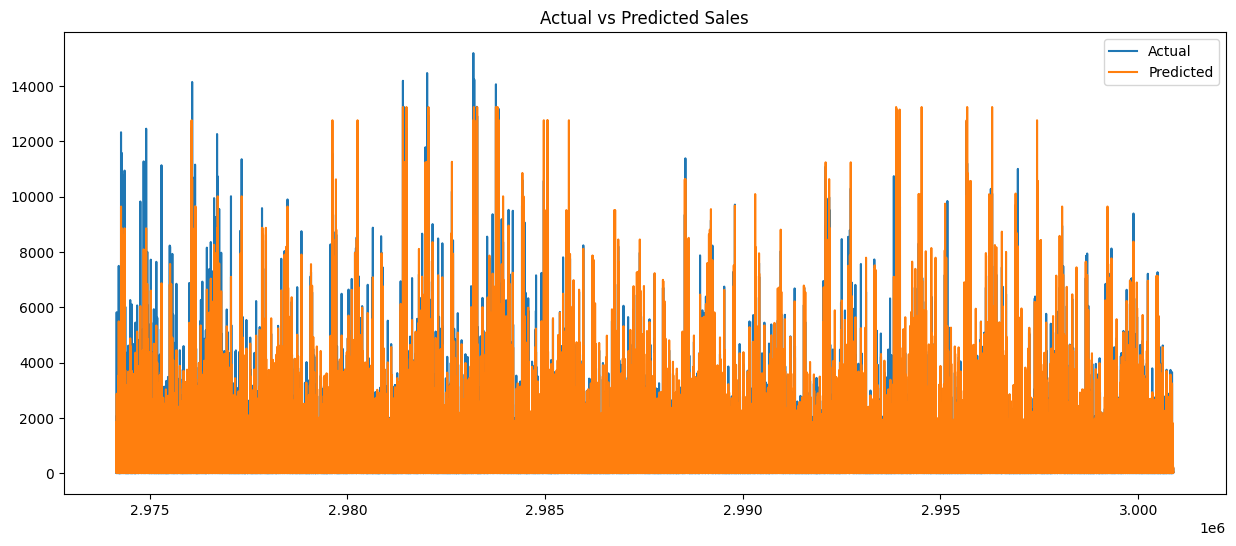

In [89]:

# Evaluate model
print("\nEvaluating model...")
metrics, test_predictions = evaluate_model(model, X_train, y_train, X_test, y_test)

# Save results
model.save_model('store_sales_model.json')

test_predictions_df = pd.DataFrame({
    'date': test_df['date'],
    'store_nbr': test_df['store_nbr'],
    'family': test_df['family'],
    'actual': y_test,
    'predicted': test_predictions
})
test_predictions_df.to_csv('test_predictions.csv', index=False)

print("\nResults saved to:")
print("- store_sales_model.json")
print("- feature_importance.csv")
print("- test_predictions.csv")

# Analysis of predictions by store and family
def analyze_predictions_by_segment():
    predictions_analysis = test_predictions_df.copy()
    predictions_analysis['error'] = predictions_analysis['actual'] - predictions_analysis['predicted']
    predictions_analysis['abs_error'] = abs(predictions_analysis['error'])
    
    # Store level analysis
    store_performance = predictions_analysis.groupby('store_nbr').agg({
        'abs_error': ['mean', 'std'],
        'error': ['mean', 'count']
    }).round(2)
    
    # Family level analysis
    family_performance = predictions_analysis.groupby('family').agg({
        'abs_error': ['mean', 'std'],
        'error': ['mean', 'count']
    }).round(2)
    
    return store_performance, family_performance

store_perf, family_perf = analyze_predictions_by_segment()
print("\nStore Performance Summary:")
print(store_perf.head())
print("\nProduct Family Performance Summary:")
print(family_perf.head())

# Plot actual vs predicted
plt.figure(figsize=(15,6))
plt.plot(test_predictions_df.index, test_predictions_df['actual'], label='Actual')
plt.plot(test_predictions_df.index, test_predictions_df['predicted'], label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

Test data shape: (28512, 6)
Test date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
Preparing features...
Last training date: 2017-08-15 00:00:00

Feature matrix shape: (28512, 8)

Features created: ['sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_lag_7', 'sales_lag_1', 'sales_rolling_mean_30', 'sales_lag_14', 'sales_lag_30', 'year']

Making predictions...
Unique predictions: [1.27371588e+01 1.27453165e+01 1.27522192e+01 ... 1.00117842e+04
 1.06327578e+04 1.27613691e+04]


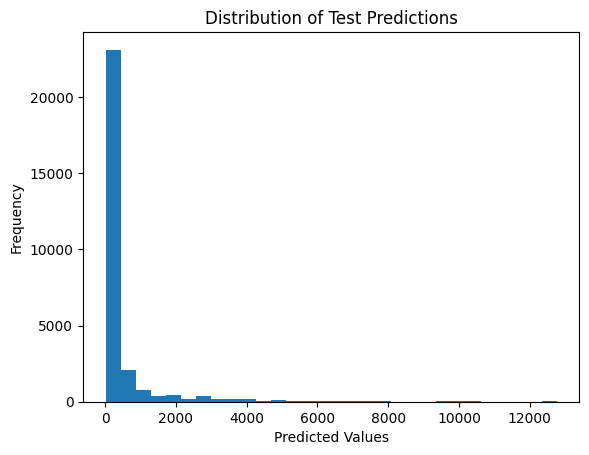

In [98]:
# forecast on the test set
test = pd.read_csv('./data/test.csv')
test['date'] = pd.to_datetime(test['date'])
test['sales'] = 0

print(f"Test data shape: {test.shape}")
print(f"Test date range: {test['date'].min()} to {test['date'].max()}")

# Create the same features as used in training
def prepare_test_features(test_df, train_df):
    """
    Create lag and rolling features for test data using training data
    """
    print("Preparing features...")
    test_features = test_df.copy()
    
    # Get last date of training data
    last_train_date = train_df['date'].max()
    print(f"Last training date: {last_train_date}")
    
    # Get last 30 days of training data (for creating lag features)
    last_30_days = train_df[train_df['date'] > last_train_date - pd.Timedelta(days=30)]
    
    # Create lag features for each store-family combination
    for (store, family), group in last_30_days.groupby(['store_nbr', 'family']):
        # Get corresponding test rows
        mask = (test_features['store_nbr'] == store) & (test_features['family'] == family)
        
        if mask.any():
            # Last known values for different lags
            last_sales = group['sales'].iloc[-1]  # Most recent sales value
            last_7_mean = group['sales'].tail(7).mean()  # Last 7 days mean
            last_14_mean = group['sales'].tail(14).mean()  # Last 14 days mean
            last_30_mean = group['sales'].tail(30).mean()  # Last 30 days mean
            
            # Create lag features
            test_features.loc[mask, 'sales_lag_1'] = last_sales
            test_features.loc[mask, 'sales_lag_7'] = group['sales'].iloc[-7] if len(group) >= 7 else last_sales
            test_features.loc[mask, 'sales_lag_14'] = group['sales'].iloc[-14] if len(group) >= 14 else last_sales
            test_features.loc[mask, 'sales_lag_30'] = group['sales'].iloc[-30] if len(group) >= 30 else last_sales
            
            # Create rolling mean features
            test_features.loc[mask, 'sales_rolling_mean_7'] = last_7_mean
            test_features.loc[mask, 'sales_rolling_mean_14'] = last_14_mean
            test_features.loc[mask, 'sales_rolling_mean_30'] = last_30_mean
    
    # Add year feature
    test_features['year'] = test_features['date'].dt.year
    
    return test_features

# Create features for test data
test_engineered = prepare_test_features(test, train)

test_engineered = handle_missing_values(test_engineered)


# Selected features (in order of importance as previously determined)
selected_features = [
    'sales_rolling_mean_7',
    'sales_rolling_mean_14',
    'sales_lag_7',
    'sales_lag_1',
    'sales_rolling_mean_30',
    'sales_lag_14',
    'sales_lag_30',
    'year'
]

# Prepare feature matrix
X_test = test_engineered[selected_features]

# Handle missing values
X_test = X_test.fillna(0)

print("\nFeature matrix shape:", X_test.shape)
print("\nFeatures created:", X_test.columns.tolist())

# 3. Make predictions
print("\nMaking predictions...")
# dtest = xgb.DMatrix(X_test)
predictions = model.predict(X_test)

# Check the unique values in the predictions
print("Unique predictions:", np.unique(predictions))

# Check the distribution of predictions
import matplotlib.pyplot as plt
plt.hist(predictions, bins=30)
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()



In [99]:
# Create submission file    
submission = pd.DataFrame({
    'id': test['id'],
    'sales': predictions
})

# Ensure predictions are non-negative
submission['sales'] = submission['sales'].clip(lower=0)

# Save submission file
submission.to_csv('submission.csv', index=False)
print("\nSubmission saved to submission.csv")


Submission saved to submission.csv
